<a href="https://colab.research.google.com/github/BilalDurmus08/100Days_Of_Python/blob/master/Dog_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [53]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Here we unziped the file
#!unzip 'drive/MyDrive/Dog vision/dog-breed-identification.zip' -d 'drive/MyDrive/Dog vision'

# End-to-End multil-class Dog Breed Classification
This notebok builds an end-to-end multi class image classifier using Tenserflow 2.0 and Tenserflow Hub.

## 1. Problem
Identifying breed of a dog given an image of a dog.

When i am sitting of a cafe and I take a photo of a dog, I want to know what breed of a dog it is.

## 2. Data
The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some iformation about the data:
* We're dealing with images (unstractured data) so it's probably best we use deeo learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set(these images have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to oredict them.)

### Get our Workplace Ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU
*  

In [7]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

print('TF version:', tf.__version__)
print('TF Hub version:', hub.__version__)

# Chgeck for GPU availability
print('GPU', 'Available (Yess!!!)' if tf.config.list_physical_devices('GPU') else 'not available')

TF version: 2.17.0
TF Hub version: 0.16.1
GPU not available


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be numerical format that's what we dooing first, turning data into tenses(numerical representation)

Let's start by acdcesing our data and checking out the labels.


In [8]:
# Bringing label.csv
import pandas as pd
import numpy as np

label_csv = pd.read_csv('drive/MyDrive/Dog vision/labels.csv')
print(label_csv.describe())
print(label_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [9]:
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


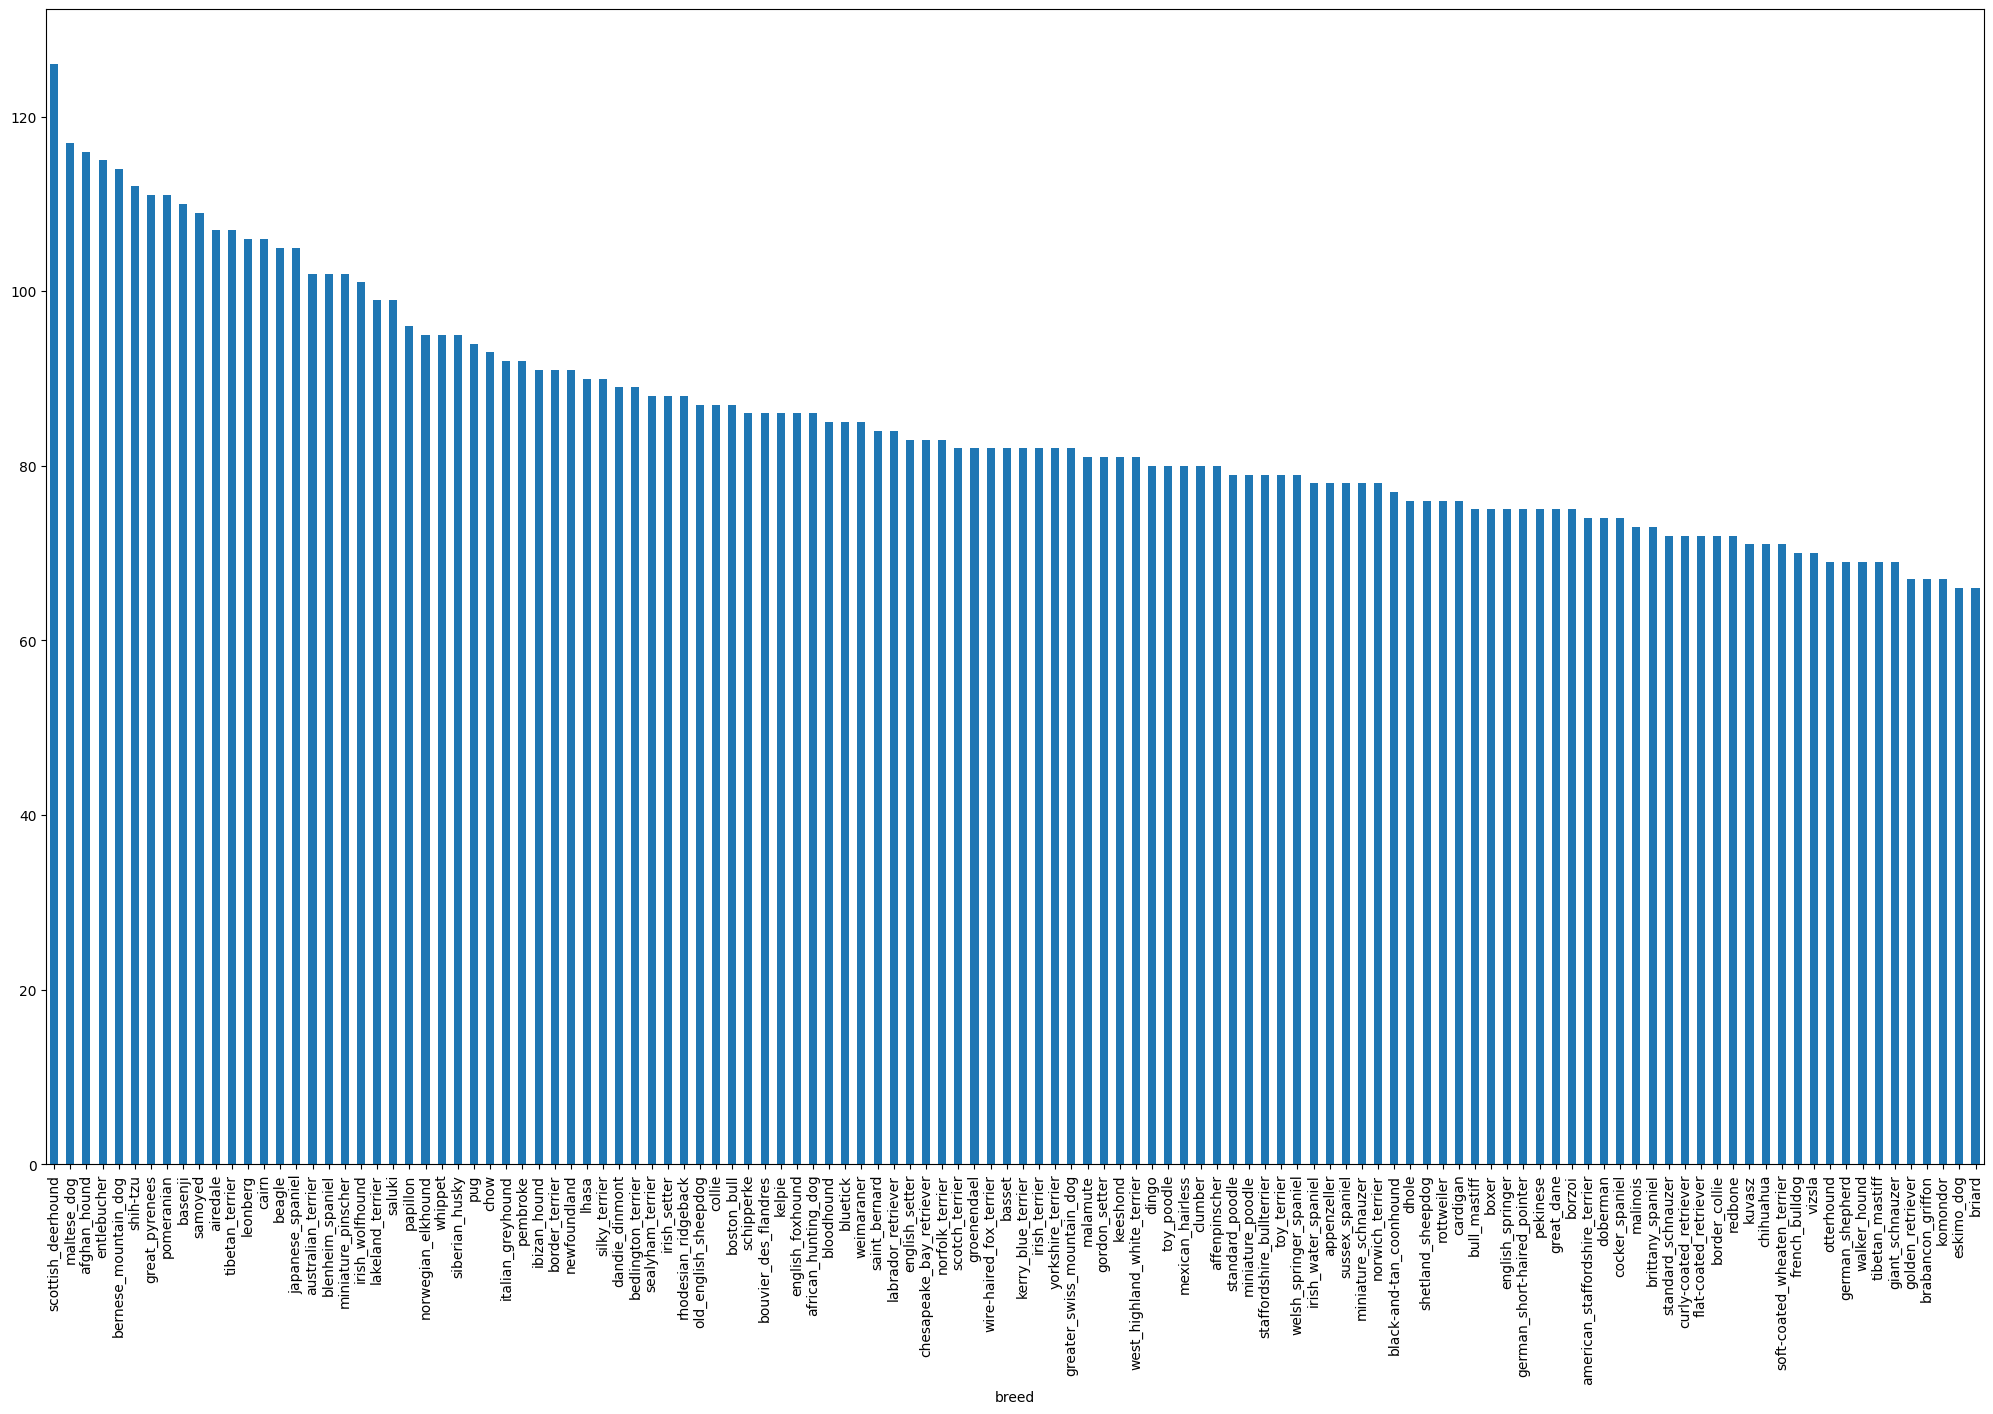

In [10]:
# How many images are there of each breed
label_csv['breed'].value_counts().plot.bar(figsize=(25,15));

In [11]:
label_csv['breed'].value_counts().mean()

85.18333333333334

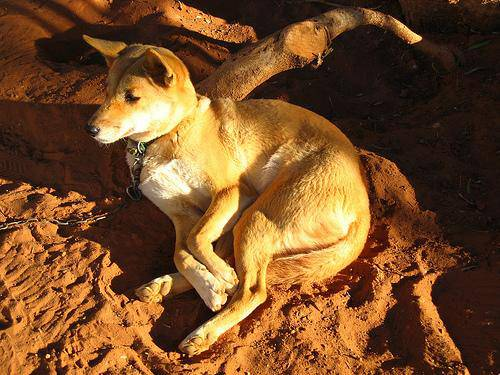

In [12]:
# Let's view an image
from IPython.display import Image
Image('drive/MyDrive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

Let's get a list of all of our image file pathnames.

In [13]:
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
# Create pathnames from image ID's
fileNames = ['drive/MyDrive/Dog vision/train/' + fName + '.jpg' for fName in label_csv['id']]

# Check the first 10
fileNames[:10]

['drive/MyDrive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [15]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('drive/MyDrive/Dog vision/train/')) == len(fileNames):
  print('Filenames matches actual amount of files !! Proceed')
else:
  print('Filenames do no match actual amount of files, check the target directory!')

Filenames matches actual amount of files !! Proceed


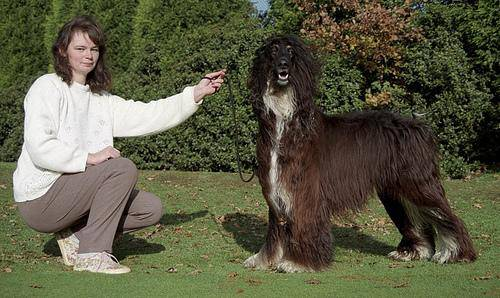

In [16]:
# One more check
Image(fileNames[8832])

In [17]:
label_csv['breed'][8832]

'afghan_hound'

Since we've now got our training image file path in a list let's prepare labels

In [18]:
labels = label_csv['breed'].to_numpy()
# labels = np.array(labels) # Does same thing above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [19]:
len(labels)

10222

In [20]:
# See if number of labels matches the number of filenames
if len(labels) == len(fileNames):
  print('Number of labels matches number of filenames!')
else:
  print('Number of labels does not match number of filenames, checj data direcroties!')

Number of labels matches number of filenames!


In [21]:
# Find the unique Label values
unique_breeds = np.unique(labels)
unique_breeds, len(unique_breeds)

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

In [22]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [23]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [24]:
len(boolean_labels)

10222

In [25]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [26]:
print(labels[3])
print(boolean_labels[3].astype(int))

bluetick
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [27]:
fileNames[:10]

['drive/MyDrive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set we're going to create our own.

In [28]:
# Setup X & y variables
X = fileNames
y = boolean_labels

In [29]:
len(X)

10222

we're going to start of experimenting with -1000- images and increase as needed

In [30]:
# Set number of images to use for experimenting
Num_Images = 1000 #@param {type:'slider', min:1000, max:10000, step:1000}

In [31]:
# Let's sp;it our data into train and validation sets
from sklearn.model_selection import train_test_split

#Split them into training and validation of total size Num_Images
X_train, X_val, y_train, y_val = train_test_split(X[:Num_Images],
                                                  y[:Num_Images],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val),

(800, 200, 800, 200)

In [32]:
# Let's have a geez at the training data
X_train[:2], y_train[:2]

(['drive/MyDrive/Dog vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

## Preprocessing Images (turning images into Tensors)

to preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Trun our image (a jpg) into Tensors
4. Resize the image to br a shape of (224,224)
5. Return the modified image

### Before we do, let's see What importing an image looks like.

In [33]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(fileNames[42])
image.shape

(257, 350, 3)

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]], dtype=uint8)
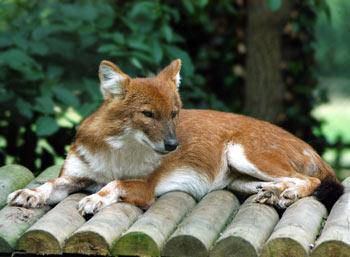

In [34]:
image #rgb codes

In [35]:
tf.constant(image)[:2] # We made it Tensor

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Trun our image (a jpg) into Tensors
4. Normalize our image (cinvert color channel values from 0-255 to 0-1)
5. Resize the image to br a shape of (224,224)
6. Return the modified image

In [36]:
# Define image size
Img_Size = 224

# Create a function for preprocessing images
def process_images(image_path, img_size = Img_Size):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image


## Turning our data into batches

Why turn our data into batches

Ler's say you're trying to process 10,000 + images in one go... they all might not fit intto memory.

So that's why we do about 32 (this is the batch size)
images at a time (you can manually adjust the batch size if need be.)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (image, label).

In [37]:
# Create a simple function retunr a tuple(image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and returns tuple of (image, label).
  """
  image = process_images(image_path)
  return image, label

In [38]:
# Demo of the above
(process_images(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [39]:
y[42]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

Now we've got a way to turn  our data into tuples of Tensors in the form: (image, label), let's make a function to turn all of our data (x & y) into batches !

In [40]:
# Define the batch size, 32 is a good start
Batch_Size = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=Batch_Size, valid_data = False, test_data = False ):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validator data.
  Also acceots test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_images).batch(batch_size)
    return data_batch

  # If the data a valid dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels

    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    # if the data is a training dataset, we shuffle it
    print('Creating training data batches...')
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turn the data into batches
    data_batch = data.batch(batch_size)
  return data_batch

In [41]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [42]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visulazing Data Batches

our data is now batches, however, these can be a little hard to ynderstrand/comprehend, let's visulize them

In [43]:
import matplotlib.pyplot as plt

# Create a fution for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data bach.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 row , 5 columns)
    ax = plt.subplot(5, 5, i+1) # column row index
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()]) # We took the 'True value'
    # Turn the grid line off
    plt.axis('off')

In [44]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [45]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[8.74509871e-01, 8.66666734e-01, 8.07843208e-01],
          [8.74509871e-01, 8.66666734e-01, 8.07843208e-01],
          [8.74509871e-01, 8.66666734e-01, 8.07843208e-01],
          ...,
          [8.71463537e-01, 8.57020438e-01, 7.99089730e-01],
          [8.69677961e-01, 8.57913256e-01, 7.99089730e-01],
          [8.69677961e-01, 8.57913256e-01, 7.99089730e-01]],
 
         [[8.74509871e-01, 8.66666734e-01, 8.07843208e-01],
          [8.74509871e-01, 8.66666734e-01, 8.07843208e-01],
          [8.74509871e-01, 8.66666734e-01, 8.07843208e-01],
          ...,
          [8.66071522e-01, 8.54306817e-01, 7.95483291e-01],
          [8.66071522e-01, 8.54306817e-01, 7.95483291e-01],
          [8.66071522e-01, 8.54306817e-01, 7.95483291e-01]],
 
         [[8.74509871e-01, 8.66666734e-01, 8.07843208e-01],
          [8.74509871e-01, 8.66666734e-01, 8.07843208e-01],
          [8.74509871e-01, 8.66666734e-01, 8.07843208e-01],
          ...,
          [8.74194741e-01, 8.62358272e-01, 8.0374

In [46]:
len(train_images), len(train_labels)

(32, 32)

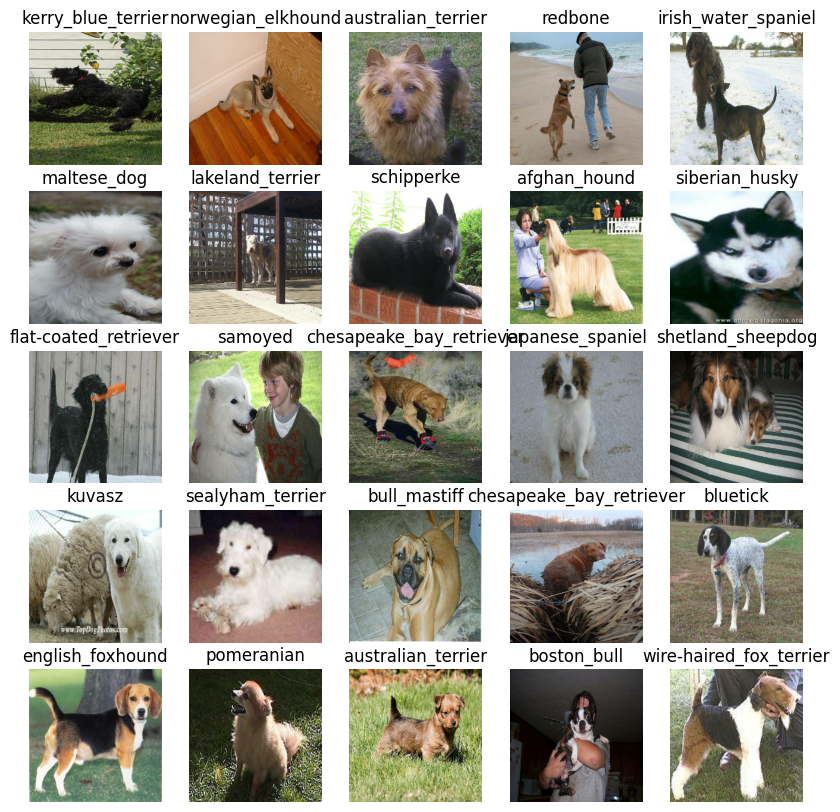

In [47]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

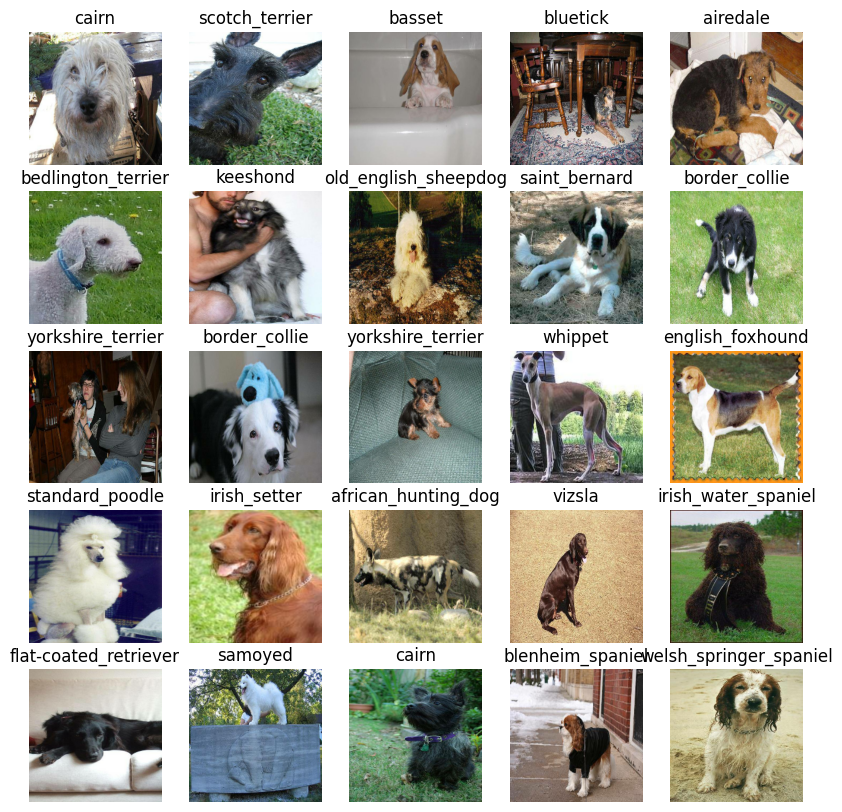

In [48]:
# Now let's visulize our  vaslidation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there asre a few things we need to define:
* The input shape(our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow hub: https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification

In [60]:
# Setup input shape to the model
INPUT_SHAPE = [None, Img_Size, Img_Size] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE =len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

Now we've got our inputs, outputs and model ready to go.
Let's put them togerher into a Keras deep learning model!

Knowing this , let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters,
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be a evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model
All the steps can be found from here:
https://www.tensorflow.org/guide/keras

In [61]:
# Create a function which builds a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print('Building model with:', model_url)

  # Setup the model layers
  model = tf.keras.Sequential([
      tf.keras.layers.Lambda(lambda x: hub.KerasLayer(model_url)(x)), # Layer 1 (Input layer)
      tf.keras.layers.Dense(units=output_shape,
                            activation='softmax') # Layer 2 (output layer)
                              ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Build the model
  model.build(input_shape)

  return model

In [62]:
model = create_model()
model.summary()

Building model with: https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_3 (Lambda)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)